# Import libraries & set options

In [1]:
!pip install tqdm
from tqdm import tqdm_notebook

  Using cached https://files.pythonhosted.org/packages/6c/4b/c38b5144cf167c4f52288517436ccafefe9dc01b8d1c190e18a6b154cd4a/tqdm-4.31.1-py2.py3-none-any.whl
You are using pip version 18.0, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import os
import numpy as np
import random as rn
import datetime
import gc;

import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 300)

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# libs for FFM embedding (absent in final model)
import tensorflow as tf
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Dense, Flatten, Concatenate, Dot, Reshape, Add, Subtract
from keras import objectives
from keras import backend as K
from keras import regularizers 
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2

Using TensorFlow backend.


Fix `seed` to make model reproducable

In [3]:
def init_seeds(seed):
    
    os.environ['PYTHONHASHSEED'] = '0'
    
    np.random.seed(seed)
    rn.seed(seed)

    # Force TensorFlow to use single thread.
    # Multiple threads are potential source of non-reproducible results.
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

    # The below tf.set_random_seed() will make random number generation
    tf.set_random_seed(seed)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)
    
    return sess

sess = init_seeds(seed=0)

Read last purchase date called `reference_date` for each `card_id` (notebook `find_last_transaction.ipynb`).

In [4]:
reference_date = pd.read_csv('saved_features_24-02/reference_date.csv', index_col=0, parse_dates=['reference_date'])
 
reference_date['reference_year'] = reference_date['reference_date'].dt.year.astype('category')
reference_date['reference_month'] = reference_date['reference_date'].dt.month.astype('category')
reference_date['reference_woy'] = reference_date['reference_date'].dt.weekofyear.astype('category')

# Load train/test

In [5]:
def load_train_test(path_to_tr, path_to_te):
    
    # read data
    tr = pd.read_csv(path_to_tr)
    te = pd.read_csv(path_to_te)
    
    # set up outliers in train
    tr['outliers'] = 0
    tr.loc[tr['target'] < -30, 'outliers'] = 1
    
    # set target as nan in test
    te['target'] = np.nan
    
    # merge train and test
    df = tr.append(te)
    del tr, te
    gc.collect()
    
    # parse date features
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['start_year'] = df['first_active_month'].dt.year.astype('category')
    df['start_month'] = df['first_active_month'].dt.month.astype('category')
    df['start_woy'] = df['first_active_month'].dt.weekofyear.astype('category')
    
    # add reference_date for new features
    df = df.merge(reference_date, on='card_id', how='left')
    
    # add new features
    df['elapsed_time'] = ((df['reference_date'] - df['first_active_month']).dt.days) // 30
    # "elapsed_time_feb" means elapsed time from current purchase to constant date
    df['elapsed_time_feb'] = ((np.datetime64('2018-04-30 23:59:59') - df['first_active_month']).dt.days) // 30
    
    df_train = df[df['target'].notnull()]
    df_test = df[df['target'].isnull()]
    
    return df_train, df_test

df_train, df_test = load_train_test(path_to_tr='all/train.csv', path_to_te='all/test.csv')

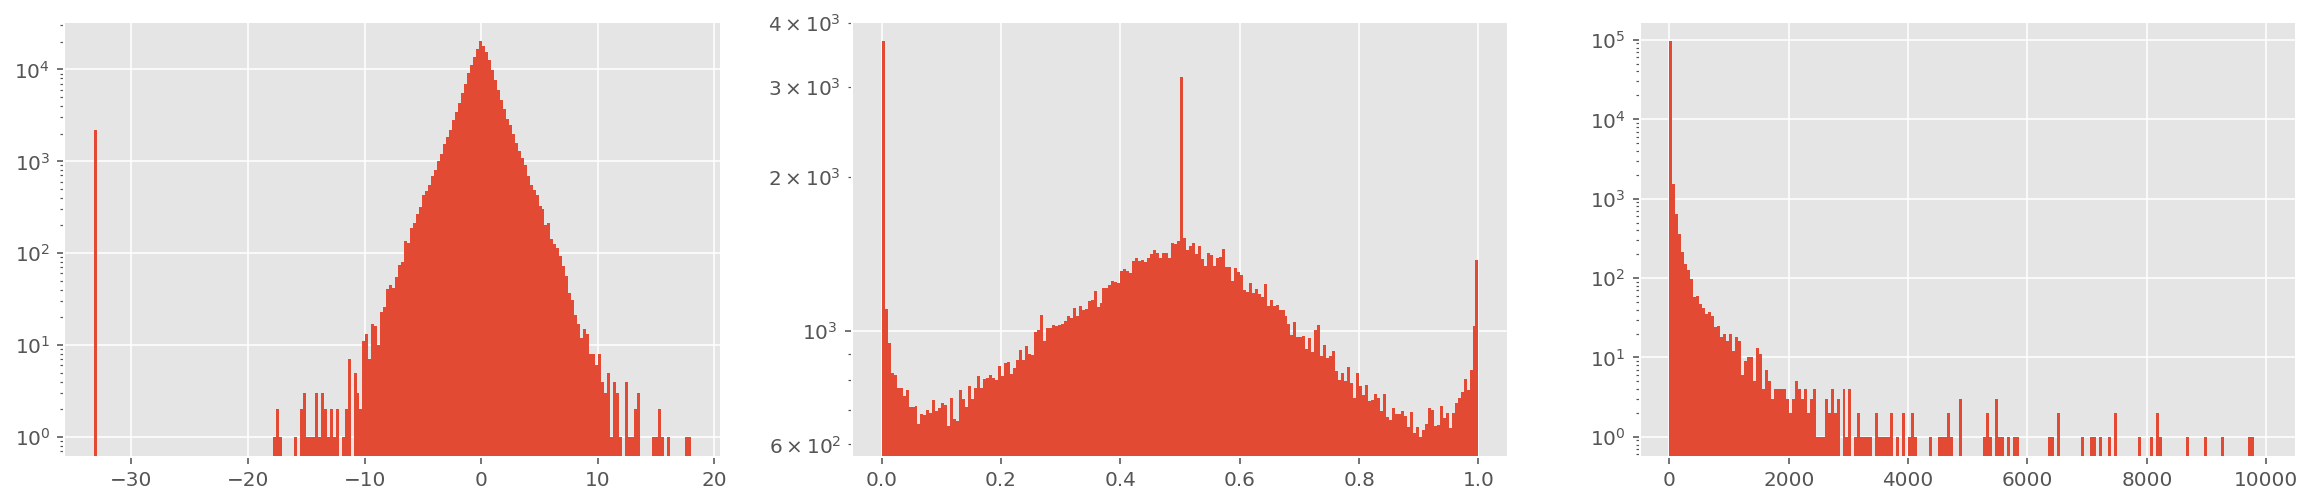

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,4), sharey=False)

ax1.hist(df_train['target'], bins=200, log=True);
ax2.hist(df_train['target'].apply(lambda x: 1 / (1 + np.exp(-x))), bins=200, log=True);
ax3.hist(df_train['target'].apply(lambda x: np.exp(x)), bins=200, log=True, range=(1, 1e4));

It is interesting that outliers in target come from `log2(1e-10) = -33.219280948873624`. So, probably, we can transform target in several ways:
    
    a) binarize target using log2(1e-n) numbers, where n = 1, 2 .., 10 assuming that target comes from original integer data (ranks from 1 to 10) and simply added noise (so, we could get rid from this noise)
    b) transform target using exponent and probably box-cox transformtion
    
    ... didn't work ...
    
    c) do nothing (my case)

In [7]:
print(np.log2(1e-10))

-33.219280948873624


# Load transactions without imputing

    Category 1 is related to International vs Local purchases that is why there is no City and State Id
    Category 2 is related to the Regions in Brazil, there is Actually 5 Regions + 1 Federate State = NaN
    Category 3 is based on how the payment is made. 
        category_3 = A -> 0 installments,
        category_3 = B -> 1 installments, 
        category_3 = C -> more than 1 installments, 
        category_3 = Nan -> -1 installments.

Using apprach below we can deanonymize `purchase_amount` variable. See `Raddar` & `CPMP` kernel for mode details.

In [32]:
# %%time
# def load_transactions(path_to_file):
#     df = pd.read_csv(path_to_file, usecols=['card_id', 'purchase_date', 'purchase_amount'], index_col=0)
#     df['purchase_date'] = pd.to_datetime(df['purchase_date'])
#     return df

# old_trans = load_transactions('all/historical_transactions.csv')
# new_trans = load_transactions('all/new_merchant_transactions.csv')

CPU times: user 1min 1s, sys: 13.2 s, total: 1min 14s
Wall time: 1min 23s


In [34]:
# old_trans['is_old'] = 1
# new_trans['is_old'] = 0

# trans = pd.concat([old_trans, new_trans]).reset_index()

# trans['new_amount'] = (trans.purchase_amount - trans.purchase_amount.min())
# s = trans.groupby('new_amount')['new_amount'].first().to_frame().reset_index(drop=True)
# s['delta'] = s.new_amount.diff(1)
# s = s[1:52623]
# trans['new_amount'] = trans.new_amount / (100 * s.delta.mean())
# trans['two_decimal_amount'] = np.round(trans['new_amount'], 2)

In [39]:
# print(trans.purchase_amount.min())
# print(100 * s.delta.mean())

-0.7469078
0.0015026511915168562


In [8]:
%%time

def load_transactions(path_to_file):
    
    df = pd.read_csv(path_to_file)
    
    # parse date features
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['purchase_woy'] = df['purchase_date'].dt.weekofyear.astype('category')
    
    # factorize binary features
    df['authorized_flag'] = df['authorized_flag'].map({'Y': 1, 'N': 0})
    df['installments'] = df['installments'].replace({-1: 0, 999: 13})
    df['purchase_amount'] = np.round((df['purchase_amount'] + 0.7469078) / 0.0015, 2)
    df['price'] = df['purchase_amount'] / (df['installments'] + 1)
    
    df = df.merge(reference_date[['card_id', 'reference_date']], on='card_id', how='left')
    
    return df

old_trans = load_transactions('all/historical_transactions.csv')
new_trans = load_transactions('all/new_merchant_transactions.csv')

# and replace (we will do it a bit later)
# old_trans.loc[old_trans['authorized_flag'] == 0, 'purchase_amount'] = 0

CPU times: user 4min, sys: 1min 1s, total: 5min 2s
Wall time: 5min 14s


In [9]:
old_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,purchase_woy,price,reference_date
0,1,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,29.05,2017-06-25 15:33:07,1.0,16,37,25,29.05,2018-04-29 18:13:17
1,1,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,9.19,2017-07-15 12:10:45,1.0,16,16,28,9.19,2018-04-29 18:13:17
2,1,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,17.68,2017-08-09 22:04:29,1.0,16,37,32,17.68,2018-04-29 18:13:17
3,1,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,7.70,2017-09-02 10:06:26,1.0,16,34,35,7.70,2018-04-29 18:13:17
4,1,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,16.03,2017-03-10 01:14:19,1.0,16,37,10,16.03,2018-04-29 18:13:17


# 1. Faled amount rate

**Only for `old_trans`**: since we have several outliers in purchase_amount with authorized_flag == 0 at the same time, we can replace them with 0. But before it we calculate sum of unsuccesful purchases for each card.

In [10]:
%%time
fail_amount = (old_trans[old_trans['authorized_flag'] == 0]
               .groupby('card_id')['purchase_amount']
               .sum()
               .reset_index()
               .rename(columns={'purchase_amount': 'failed_purchase_amount'})
              )
succ_amount = (old_trans[old_trans['authorized_flag'] == 1]
               .groupby('card_id')['purchase_amount']
               .sum()
               .reset_index()
               .rename(columns={'purchase_amount': 'succeed_purchase_amount'})
              )

failed_amount_rate = succ_amount.merge(fail_amount, how='left', on='card_id')
failed_amount_rate['failed_purchase_amount'].fillna(0, inplace=True)
failed_amount_rate['failed_purchase_amount_rate'] = (
    failed_amount_rate['failed_purchase_amount'] / failed_amount_rate['succeed_purchase_amount'])

# failed_purchase_amount_rate
failed_amount_rate.to_csv('saved_features_24-02/failed_amount_rate.csv')

CPU times: user 26.6 s, sys: 20.6 s, total: 47.2 s
Wall time: 48.8 s


# Prepare data !
    
Only for `old_trans`

In [9]:
# and replace
old_trans.loc[old_trans['authorized_flag'] == 0, 'purchase_amount'] = 0
gc.collect()

6535

Also we reduced number of large numbers in `purchase_amount`

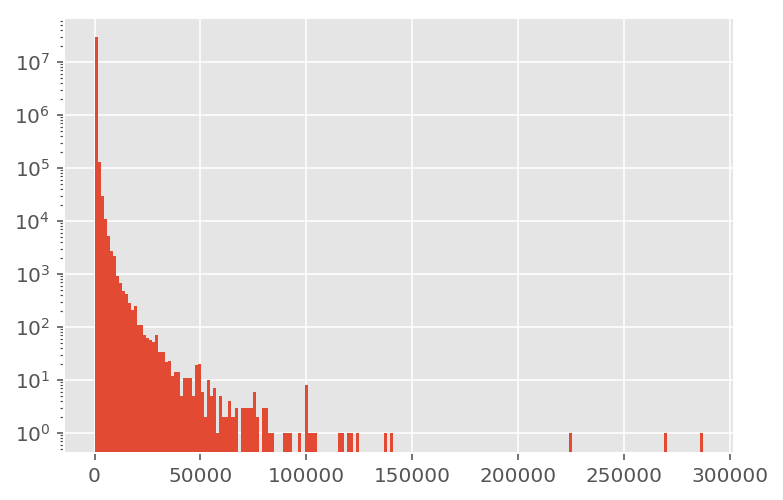

In [50]:
old_trans['purchase_amount'].hist(bins=200, log=True, figsize=(6,4));

# 2. Merchants features

## Merch rate by lag 

    new_mean_cnt / old_mean_cnt

In [51]:
old_merch_rate = old_trans[['card_id', 'month_lag', 'merchant_id']]
new_merch_rate = new_trans[['card_id', 'month_lag', 'merchant_id']]

old_merch_rate['set'] = 'old'
new_merch_rate['set'] = 'new'

merch_rate_by_lag = pd.concat([old_merch_rate, new_merch_rate])

In [53]:
%%time
agg_merch_rate_by_lag = (merch_rate_by_lag
                         .groupby(['card_id', 'month_lag', 'set'])['merchant_id']
                         .agg('count')
                         .reset_index()
                        )

ex = pd.pivot_table(agg_merch_rate_by_lag, index=['card_id', 'month_lag'], values='merchant_id', columns='set', fill_value=0).reset_index()

only_new = ex[ex['month_lag'].isin([1, 2])]
only_old = ex[ex['month_lag'].isin(range(-13, 1))]

# For NEW
new_grouping = (only_new.groupby('card_id')['new']
                .agg('sum')
                .reset_index()
                .rename(columns={'new': 'new_merch_cnt_mean_by_lag'})
               )
new_grouping['new_merch_cnt_mean_by_lag'] /= 2

# For OLD
old_grouping = (only_old.groupby('card_id')['old']
                .agg('sum')
                .reset_index()
                .rename(columns={'old': 'old_merch_cnt_mean_by_lag'})
               )
old_month_counting = (only_old.groupby('card_id')['month_lag']
                      .min()
                      .reset_index()
                      .rename(columns={'month_lag': 'month_lag_cnt'})
                     )
old_month_counting['month_lag_cnt'] = abs(old_month_counting['month_lag_cnt'])

old_grouping = old_grouping.merge(old_month_counting, on='card_id')
old_grouping['old_merch_cnt_mean_by_lag'] = old_grouping['old_merch_cnt_mean_by_lag'] / (old_grouping['month_lag_cnt'] + 1)

# Concat
grouping = pd.merge(old_grouping[['card_id', 'old_merch_cnt_mean_by_lag']], new_grouping, how='left', on='card_id')
grouping.fillna(0, inplace=True)

grouping['merch_cnt_mean_rate_by_lag'] = grouping['new_merch_cnt_mean_by_lag'] / grouping['old_merch_cnt_mean_by_lag']
# del grouping['old_merch_cnt_mean_by_lag'], grouping['new_merch_cnt_mean_by_lag']

grouping.to_csv('saved_features_24-02/merch_grouping.csv')

CPU times: user 20.6 s, sys: 3.33 s, total: 23.9 s
Wall time: 24.8 s


In [55]:
grouping.head(3)

,card_id,old_merch_cnt_mean_by_lag,new_merch_cnt_mean_by_lag,merch_cnt_mean_rate_by_lag
0,C_ID_00007093c1,11.461538,1.0,0.087248
1,C_ID_0001238066,20.500000,12.5,0.609756
2,C_ID_0001506ef0,4.714286,0.5,0.106061


## Merch amount rate by lag 

    new_mean_amount / old_mean_amount

In [54]:
old_merch_rate = old_trans[['card_id', 'month_lag', 'purchase_amount', 'merchant_id']]
new_merch_rate = new_trans[['card_id', 'month_lag', 'purchase_amount', 'merchant_id']]

old_merch_rate['set'] = 'old'
new_merch_rate['set'] = 'new'

merch_rate_by_lag = pd.concat([old_merch_rate, new_merch_rate])

In [56]:
agg_merch_rate_by_lag = (merch_rate_by_lag
                         .groupby(['card_id', 'month_lag', 'set'])['purchase_amount']
                         .agg('sum')
                         .reset_index()
                        )

ex = pd.pivot_table(agg_merch_rate_by_lag, index=['card_id', 'month_lag'], values='purchase_amount', columns='set', fill_value=0).reset_index()

only_new = ex[ex['month_lag'].isin([1, 2])]
only_old = ex[ex['month_lag'].isin(range(-13, 1))]

# For NEW
new_grouping = (only_new.groupby('card_id')['new']
                .agg('sum')
                .reset_index()
                .rename(columns={'new': 'new_amount_mean_by_lag'})
               )
new_grouping['new_amount_mean_by_lag'] /= 2

# For OLD
old_grouping = (only_old.groupby('card_id')['old']
                .agg('sum')
                .reset_index()
                .rename(columns={'old': 'old_amount_mean_by_lag'})
               )
old_month_counting = (only_old.groupby('card_id')['month_lag']
                      .min()
                      .reset_index()
                      .rename(columns={'month_lag': 'month_lag_cnt'})
                     )
old_month_counting['month_lag_cnt'] = abs(old_month_counting['month_lag_cnt'])

old_grouping = old_grouping.merge(old_month_counting, on='card_id')
old_grouping['old_amount_mean_by_lag'] = old_grouping['old_amount_mean_by_lag'] / (old_grouping['month_lag_cnt'] + 1)

# Concat
grouping = pd.merge(old_grouping[['card_id', 'old_amount_mean_by_lag']], new_grouping, how='left', on='card_id')
grouping.fillna(0, inplace=True)

grouping['merch_amount_rate_by_lag'] = grouping['new_amount_mean_by_lag'] / grouping['old_amount_mean_by_lag']
# del grouping['old_AMOUNT_mean'], grouping['new_AMOUNT_mean']

grouping.to_csv('saved_features_24-02/amount_grouping.csv')

In [57]:
grouping.head(3)

,card_id,old_amount_mean_by_lag,new_amount_mean_by_lag,merch_amount_rate_by_lag
0,C_ID_00007093c1,1164.323077,55.100,0.047324
1,C_ID_0001238066,2107.971667,1523.185,0.722583
2,C_ID_0001506ef0,695.820000,15.490,0.022262


## Merch popularity 

In [58]:
# for categories
merch_cat_popularity = ((1 / np.log1p(old_trans['merchant_category_id'].value_counts()))
                        .reset_index(drop=False)
                        .rename(columns={'merchant_category_id': 'merchant_cat_popularity',
                                         'index':'merchant_category_id'})
                       )
new_trans_merch_cat = new_trans[['card_id', 'merchant_category_id']]
new_trans_merch_cat = new_trans_merch_cat.merge(merch_cat_popularity, on='merchant_category_id', how='left')
new_trans_merch_cat = new_trans_merch_cat.groupby('card_id')['merchant_cat_popularity'].mean().reset_index()


# for merchants
merch_popularity = ((1 / np.log1p(old_trans['merchant_id'].value_counts()))
                        .reset_index(drop=False)
                        .rename(columns={'merchant_id': 'merchant_popularity',
                                         'index':'merchant_id'})
                       )
new_trans_merch = new_trans[['card_id', 'merchant_id']]
new_trans_merch = new_trans_merch.merge(merch_popularity, on='merchant_id', how='left')
new_trans_merch = new_trans_merch.groupby('card_id')['merchant_popularity'].mean().reset_index()

# combine
merch_pop = new_trans_merch_cat.merge(new_trans_merch, on='card_id')

merch_pop.to_csv('saved_features_24-02/merch_pop.csv')

In [59]:
merch_pop.head(3)

,card_id,merchant_cat_popularity,merchant_popularity
0,C_ID_00007093c1,0.075028,0.071816
1,C_ID_0001238066,0.074829,0.167126
2,C_ID_0001506ef0,0.072763,0.176264


## How many purchases with the same amount

    purchase_amount_rnd -> ohe -> PCA 

In [12]:
# OLD
old_trans['purchase_amount_rnd'] = round(old_trans['purchase_amount'], -1)

old_trans['purchase_amount_rnd1'] = old_trans['purchase_amount_rnd'].map(
    (old_trans['purchase_amount_rnd'].value_counts() / old_trans['purchase_amount_rnd'].value_counts().sum()).to_dict())

# NEW
new_trans['purchase_amount_rnd'] = round(new_trans['purchase_amount'], -1)

new_trans['purchase_amount_rnd1'] = new_trans['purchase_amount_rnd'].map(
    (new_trans['purchase_amount_rnd'].value_counts() / new_trans['purchase_amount_rnd'].value_counts().sum()).to_dict())

In [13]:
new_ex = new_trans[['card_id', 'purchase_amount_rnd1']]
old_ex = old_trans[['card_id', 'purchase_amount_rnd1']]

In [14]:
v = old_ex['purchase_amount_rnd1'].value_counts().index
k = range(len(v))

old_ex['purc_cat'] = old_ex['purchase_amount_rnd1'].map(pd.Series(k, v).to_dict())

old_ex_piv = pd.pivot_table(old_ex, index='card_id', columns='purc_cat', values='purchase_amount_rnd1',
                            aggfunc='sum', fill_value=0)

In [15]:
old_ex_piv.head()

purc_cat,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,...,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476
card_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C_ID_00007093c1,0.306632,1.843782,4.112013,1.348457,0.351328,0.402243,0.248379,0.097407,0.147572,0.107844,0.020715,0.090406,0.150446,0.050835,0.049461,0.022817,0.018453,0.032778,0.000000,0.007715,0.006236,0.004775,0.022701,0.004011,0.000000,0.011026,0.007122,0.002999,0.000000,0.002689,0.002275,0.000000,0.000000,0.000000,0.0,0.000000,0.001636,0.0,0.00301,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000805,0.0,0.000000,0.000000,0.0,0.000619,0.000000,0.000597,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000194,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C_ID_0001238066,2.146427,0.992806,0.352458,1.244729,0.421594,0.804487,0.413965,0.162345,0.265630,0.053922,0.082860,0.030135,0.030089,0.063544,0.024730,0.068452,0.009227,0.024583,0.008053,0.000000,0.006236,0.009550,0.013621,0.004011,0.003924,0.003675,0.000000,0.005998,0.000000,0.000000,0.002275,0.001941,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.001195,0.001074,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000364,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00011,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.

In [16]:
from sklearn.decomposition import PCA

def PCA_decomposition(pivot, size, feature_name):
    
    pca = PCA(n_components=size)
    
    X = pivot.values
    pca.fit(X)
    X = pca.transform(X)
    print(pca.explained_variance_ratio_)  

    pca_df = pd.DataFrame({'card_id': pivot.index})

    for i in range(size):
        pca_comp = feature_name + str(i+1)
        pca_df[pca_comp] = X[:, i]
        
    return pca_df

old_ex_cost_pca = PCA_decomposition(pivot=old_ex_piv, size=4, feature_name='purc_cat')

old_ex_cost_pca.to_csv('saved_features_24-02/old_ex_cost_pca.csv')

[0.79464356 0.0978017  0.07348477 0.02357025]


In [17]:
v = new_ex['purchase_amount_rnd1'].value_counts().index
k = range(len(v))

new_ex['purc_cat'] = new_ex['purchase_amount_rnd1'].map(pd.Series(k, v).to_dict())

new_ex_piv = pd.pivot_table(new_ex, index='card_id', columns='purc_cat', values='purchase_amount_rnd1',
                            aggfunc='sum', fill_value=0)

In [18]:
new_ex_piv.head()

purc_cat,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
card_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C_ID_00007093c1,0.000000,0.000000,0.000000,0.000000,0.075346,0.048665,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
C_ID_0001238066,0.137965,0.132458,0.325448,0.231386,0.226039,0.048665,0.039139,0.036361,0.000000,0.026162,0.0,0.037744,0.018134,0.0,0.00000,0.014581,0.0,0.011226,0.010105,0.010074,0.000000,0.0,0.0,0.005532,0.000000,0.0,0.0,0.004062,0.0,0.0,0.0,0.002808,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.001572,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
C_ID_0001506ef0,0.137965,0.132458,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.

In [20]:
from sklearn.decomposition import PCA

def PCA_decomposition(pivot, size, feature_name):
    
    pca = PCA(n_components=size)
    
    X = pivot.values
    pca.fit(X)
    X = pca.transform(X)
    print(pca.explained_variance_ratio_)  

    pca_df = pd.DataFrame({'card_id': pivot.index})

    for i in range(size):
        pca_comp = feature_name + str(i+1)
        pca_df[pca_comp] = X[:, i]
        
    return pca_df

new_ex_cost_pca = PCA_decomposition(pivot=new_ex_piv, size=5, feature_name='purc_cat')

new_ex_cost_pca.to_csv('saved_features_24-02/new_ex_cost_pca.csv')

[0.60309429 0.18936476 0.11009066 0.04252172 0.03060246]


# 3. Avg purchases for each reference period 

How much cash users tend to spend depend on seasonality (woy)

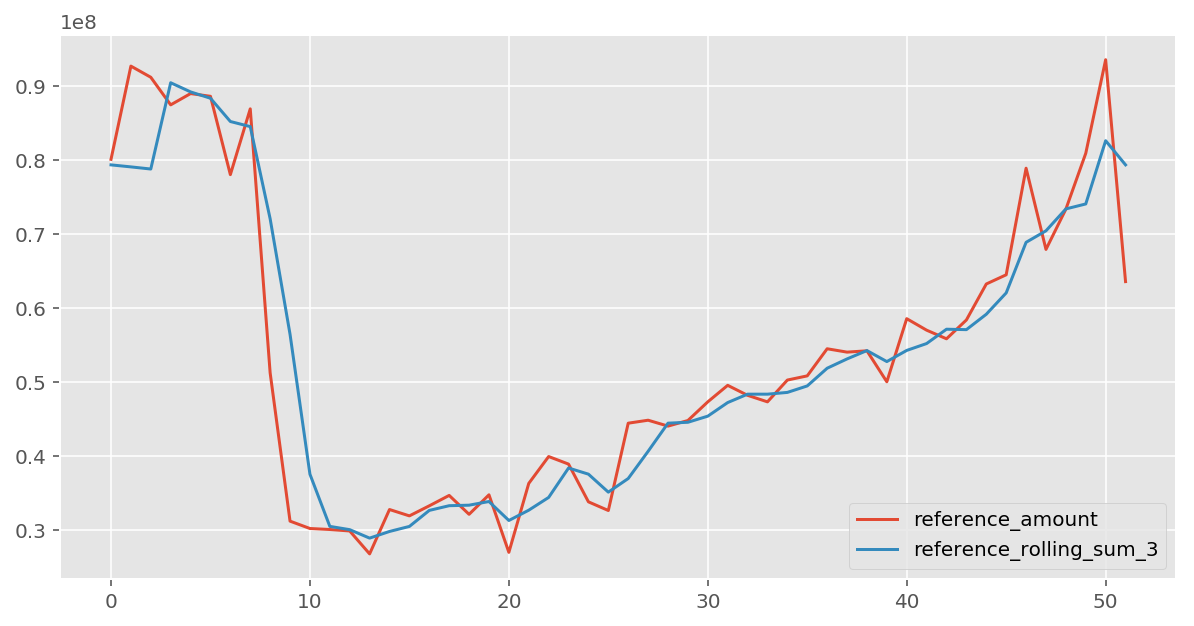

In [21]:
woy_purchase = (old_trans.groupby('purchase_woy')['purchase_amount']
                .sum()
                .reset_index()
                .rename(columns={'purchase_woy': 'reference_woy',
                                 'purchase_amount': 'reference_amount'})
               )

# normalize
# woy_purchase['reference_amount'] = woy_purchase['reference_amount'] / woy_purchase['reference_amount'].max()
woy_purchase['reference_amount'] = woy_purchase['reference_amount'] 

# rolling
woy_purchase['reference_rolling_sum_3'] = 0
woy_purchase['reference_rolling_sum_3'] = woy_purchase['reference_amount'].rolling(3, min_periods=3).sum()
woy_purchase.loc[0, 'reference_rolling_sum_3'] = woy_purchase['reference_amount'][-3:].sum()
woy_purchase.loc[1, 'reference_rolling_sum_3'] = woy_purchase['reference_amount'][-2:].sum() + woy_purchase['reference_amount'][0]
woy_purchase.loc[2, 'reference_rolling_sum_3'] = woy_purchase['reference_amount'][-1:].sum() + woy_purchase['reference_amount'][:2].sum()

# normalize
woy_purchase['reference_rolling_sum_3'] = woy_purchase['reference_rolling_sum_3'] / 3

woy_purchase.plot(figsize=(10,5));

In [22]:
del woy_purchase['reference_amount']
gc.collect()

woy_purchase.to_csv('saved_features_24-02/woy_purchase.csv')

# 4. Failed transactions

Only for `old_trans`

User most likely will upset if several failed transaction occur. We are going to detect sequentially authorized_flag == 0 features and probably after this a huge gap in transaction

In [36]:
def zero_runs(a):
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges

In [37]:
%%time
old_trans_auth = (old_trans[['card_id', 'purchase_date', 'authorized_flag', 'reference_date']]
                  .sort_values(by=['card_id', 'purchase_date'])
                  .set_index('card_id')
                 )

CPU times: user 47.1 s, sys: 3.56 s, total: 50.7 s
Wall time: 50.8 s


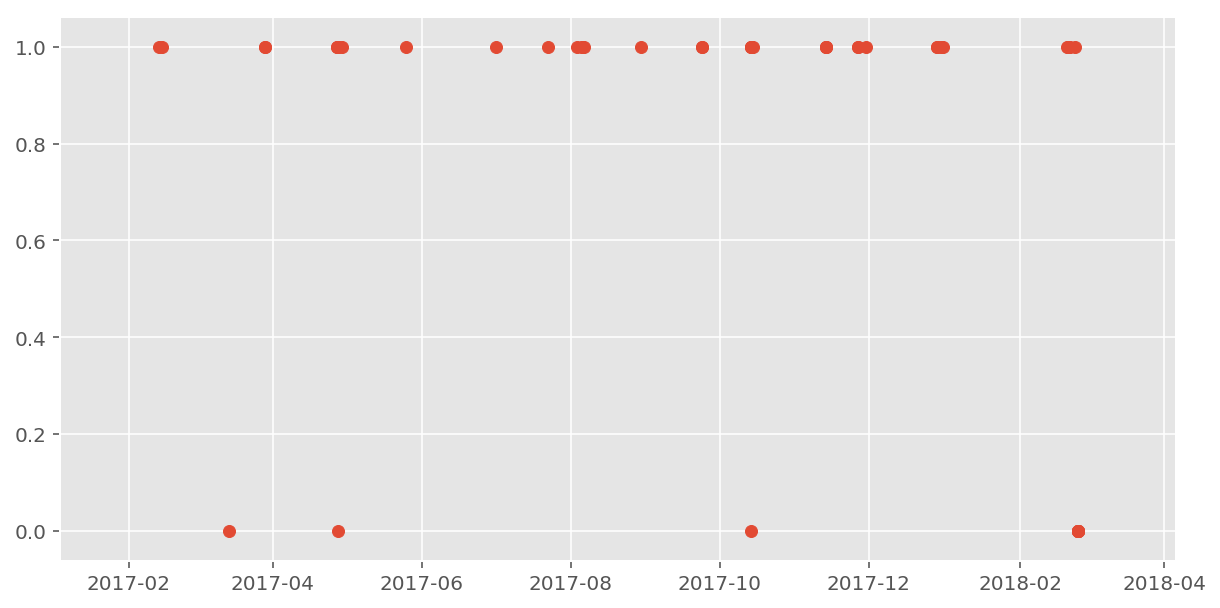

In [94]:
tr = old_trans_auth.loc['C_ID_fda64b25e4'].reset_index()

plt.figure(figsize=(10, 5))
plt.scatter(tr['purchase_date'].values, tr['authorized_flag']);

In [102]:
failed_trans = {}
for card_id in tqdm_notebook(old_trans_auth.index.unique()):

    tr = old_trans_auth.loc[card_id].reset_index()
    tr_failed = tr[tr['authorized_flag'] == 0]

    # 1. add avg "distance" between failed transactions
    if len(tr_failed) > 1:
        failed_gap = (tr_failed['purchase_date'] - tr_failed['purchase_date'].shift(1)).apply(lambda x: x.days * 24 + x.seconds // 60 // 60)
        failed_gap_mean = np.nanmean(failed_gap)
        failed_gap_median = np.nanmedian(failed_gap)
        failed_gap_max = np.nanmax(failed_gap)
        failed_gap_min = np.nanmin(failed_gap)
    else:
        failed_gap_mean = 0
        failed_gap_median = 0
        failed_gap_max = 0
        failed_gap_min = 0
        
    # 2. add days since last failed transaction to reference_date
    if len(tr_failed) > 1:
        gap_fail_to_reference = (tr_failed['reference_date'].iloc[-1] -  tr_failed['purchase_date'].iloc[-1]).days
        gap_fail_to_reference_feb = (np.datetime64('2018-04-30 23:59:59') -  tr_failed['purchase_date']).iloc[-1].days
    else:
        gap_fail_to_reference = np.nan
        gap_fail_to_reference_feb = np.nan

    # 3. how many trailing last failed transactions
    trailing_zeros = 0
    tr_trailing_zeros = tr['authorized_flag']
    while tr_trailing_zeros.iloc[-1] == 0:
        tr_trailing_zeros = tr_trailing_zeros[:-1]
        trailing_zeros += 1

    # 4. add average waiting time before succusfull transasction
    runs = zero_runs(tr['authorized_flag'])
    if len(runs) > 0:
        failed_dur_list = []
        for pair in runs:
            i, j = pair
            try:
                failed_dur = ((tr.loc[j]['purchase_date'] - tr.loc[i]['purchase_date']).days * 24 +
                              (tr.loc[j]['purchase_date'] - tr.loc[i]['purchase_date']).seconds // 60 // 60
                             )
            except: # ends with 0
                failed_dur = ((tr.loc[j-1]['purchase_date'] - tr.loc[i-1]['purchase_date']).days * 24 + 
                              (tr.loc[j-1]['purchase_date'] - tr.loc[i-1]['purchase_date']).seconds // 60 // 60
                             )
            failed_dur_list.append(failed_dur)

        avg_waiting = np.mean(np.array(failed_dur_list))
        max_waiting = np.max(np.array(failed_dur_list))
    else:
        avg_waiting = 0
        max_waiting = 0

    # 5. add other features
    runs_distr = runs[:,1] - runs[:,0]

    if len(runs_distr) > 0:
        # avg number of all sequential failed transactions 
        runs_distr_mean = np.mean(runs_distr)
        # median of all sequential failed transactions 
        runs_distr_median = np.median(runs_distr)
        # max value of all sequential failed transactions 
        runs_distr_max = np.max(runs_distr)
        # number of sequential failed transactions 
        runs_distr_size = np.size(runs_distr)
    else:
        runs_distr_mean = 0
        runs_distr_max = 0
        runs_distr_size = 0


    failed_trans[card_id] = [

        # 1. add avg "distance" between failed transactions
        failed_gap_mean, failed_gap_median, failed_gap_max, failed_gap_min,

        # 2. add days since last failed transaction to reference_date
        gap_fail_to_reference, gap_fail_to_reference_feb,

        # 3. is last transaction failed? number of last failed transactions
        trailing_zeros,

        # 4. add average waiting time before succusfull transasction
        avg_waiting, max_waiting,

        # 5. add other features
        runs_distr_mean, runs_distr_median, runs_distr_max, runs_distr_size
    ]


# save to df
failed_trans_df = pd.DataFrame().from_dict(
    failed_trans, 
    orient='index', 
    columns=['failed_gap_mean', 'failed_gap_median', 'failed_gap_max', 'failed_gap_min',
             'gap_fail_to_reference', 'gap_fail_to_reference_feb',
             'trailing_zeros',
             'avg_waiting', 'max_waiting', 
             'runs_distr_mean', 'runs_distr_median', 'runs_distr_max', 'runs_distr_size']
)

failed_trans_df = (failed_trans_df
                   .reset_index()
                   .rename(columns={'index': 'card_id'})
                  )

# save to csv
failed_trans_df.to_csv('saved_features_24-02/failed_trans_df.csv')

# 4. Gradients

For `old_trans` and `new_trans`.

Calculate weighted by `moth_lag` (log scale) difference between next values:

In [41]:
%%time

def gradient_features(df, new_set=False):
    
    grouped_by_lag = (df.groupby(['card_id', 'month_lag'])[['purchase_amount', 'authorized_flag']]
                      .agg(['sum', 'mean', 'count'])
                      .reset_index()
                     )
    grouped_by_lag.columns = ['_'.join(col).strip() for col in grouped_by_lag.columns.values]
    grouped_by_lag = grouped_by_lag.rename(columns={'card_id_': 'card_id', 'month_lag_': 'month_lag'})
    
    gradients = {}
    for card, v in tqdm_notebook(grouped_by_lag.groupby('card_id')):
        
        if len(v) > 1:

            # purchase_amount
            diff_purchase_sum = (v['purchase_amount_sum'] - v['purchase_amount_sum'].shift()).reset_index(drop=True)[1:]
            diff_purchase_sum_avg = np.mean(diff_purchase_sum)
            diff_purchase_sum_wavg = np.average(diff_purchase_sum, weights=np.log1p(diff_purchase_sum.index))

            diff_purchase_mean = (v['purchase_amount_mean'] - v['purchase_amount_mean'].shift()).reset_index(drop=True)[1:]
            diff_purchase_mean_avg = np.mean(diff_purchase_mean)
            diff_purchase_mean_wavg = np.average(diff_purchase_mean, weights=np.log1p(diff_purchase_mean.index))

            diff_purchase_count = (v['purchase_amount_count'] - v['purchase_amount_count'].shift()).reset_index(drop=True)[1:]
            diff_purchase_count_avg = np.mean(diff_purchase_count)
            diff_purchase_count_wavg = np.average(diff_purchase_count, weights=np.log1p(diff_purchase_count.index))

            # authorized_flag (count will be the same)
            diff_auth_sum = (v['authorized_flag_sum'] - v['authorized_flag_sum'].shift()).reset_index(drop=True)[1:]
            diff_auth_sum_avg = np.mean(diff_auth_sum)
            diff_auth_sum_wavg = np.average(diff_auth_sum, weights=np.log1p(diff_auth_sum.index))

            diff_auth_mean = (v['authorized_flag_mean'] - v['authorized_flag_mean'].shift()).reset_index(drop=True)[1:]
            diff_auth_mean_avg = np.mean(diff_auth_mean)
            diff_auth_mean_wavg = np.average(diff_auth_mean, weights=np.log1p(diff_auth_mean.index))

            gradients[card] = [diff_purchase_sum_avg, diff_purchase_sum_wavg, 
                               diff_purchase_mean_avg, diff_purchase_mean_wavg,
                               diff_purchase_count_avg, diff_auth_sum_wavg, 
                               diff_auth_mean_avg, diff_auth_mean_wavg]
        
        else:
            gradients[card] = [0, 0, 0, 0, 0]

    # save to df
    gradients_df = pd.DataFrame().from_dict(
        gradients, orient='index', 
        columns=['diff_purchase_sum_avg', 'diff_purchase_sum_wavg', 
                 'diff_purchase_mean_avg', 'diff_purchase_mean_wavg',
                 'diff_purchase_count_avg', 'diff_auth_sum_wavg', 
                 'diff_auth_mean_avg', 'diff_auth_mean_wavg']
    )

    gradients_df = (gradients_df
                    .reset_index(drop=False)
                    .rename(columns={'index': 'card_id'})
                   )
    
    if new_set:
        gradients_df.columns = 'new_' + gradients_df.columns
        gradients_df = gradients_df.rename(columns={'new_card_id': 'card_id'})
    else:
        gradients_df.columns = 'old_' + gradients_df.columns
        gradients_df = gradients_df.rename(columns={'old_card_id': 'card_id'})
    
    return gradients_df

old_gradients_df = gradient_features(old_trans)
new_gradients_df = gradient_features(new_trans, new_set=True)

# save to csv
old_gradients_df.to_csv('saved_features_24-02/old_gradients_df.csv')
new_gradients_df.to_csv('saved_features_24-02/new_gradients_df.csv')


CPU times: user 33min 47s, sys: 4min 47s, total: 38min 35s
Wall time: 5h 13min 56s


# 5. OLS regression

---
due to memory problem let's restart kernel and load limited dataset

In [6]:
# %%time

# def load_transactions(path_to_file):

#     df = pd.read_csv(path_to_file, usecols=[
#         'card_id', 'purchase_date', 'authorized_flag', 
#         'category_1', 'category_2', 'category_3', 
#         'installments', 'purchase_amount'])
    
#     # parse date features
#     df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    
#     # factorize binary features
#     df['authorized_flag'] = df['authorized_flag'].map({'Y': 1, 'N': 0})
#     df['category_1'] = df['category_1'].map({'Y': 1, 'N': 0})
    
#     # fill nans
#     df['category_2'].fillna(6.0, inplace=True)
#     df['category_3'].fillna('A', inplace=True)
#     df['installments'] = df['installments'].replace({-1: 0, 999: 13})
    
#     # add features
#     df['purchase_amount'] = df['purchase_amount'].apply(lambda x: 1 / (1 + np.exp(-x)))
#     df['price'] = df['purchase_amount'] / (df['installments'] + 1)

#     return df

# old_trans = load_transactions('../../all/historical_transactions.csv')
# new_trans = load_transactions('../../all/new_merchant_transactions.csv')

# # and replace
# old_trans.loc[old_trans['authorized_flag'] == 0, 'purchase_amount'] = 0

CPU times: user 2min 48s, sys: 27.5 s, total: 3min 16s
Wall time: 3min 26s


In [9]:
%%time
old_trans_weekly = (old_trans.groupby(['card_id', pd.Grouper(key='purchase_date', freq='W')])['purchase_amount']
                    .sum()
                    .reset_index()
                    .set_index('card_id')
                   )

new_trans_weekly = (new_trans.groupby(['card_id', pd.Grouper(key='purchase_date', freq='W')])['purchase_amount']
                    .sum()
                    .reset_index()
                    .set_index('card_id')
                   )

CPU times: user 3min 25s, sys: 50 s, total: 4min 15s
Wall time: 4min 14s


In [10]:
old_trans_weekly.head()

,purchase_date,purchase_amount
card_id,,
C_ID_00007093c1,2017-02-19,825.26
C_ID_00007093c1,2017-02-26,276.89
C_ID_00007093c1,2017-03-05,175.31
C_ID_00007093c1,2017-03-12,693.13
C_ID_00007093c1,2017-03-19,0.00


235.5565046382189 569.1474199134209 0.9895295238352876 7.8822091560874545


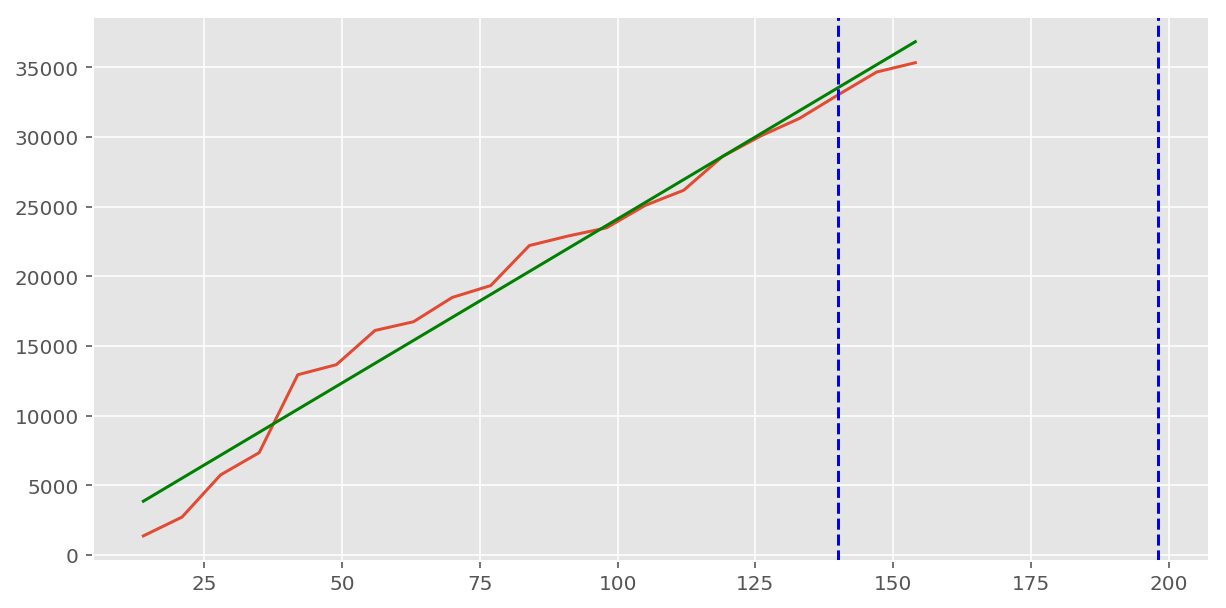

In [16]:
from scipy import stats

sk_subs_id = df_train.sample()['card_id'].values[0]
purchase_date_st = df_train[df_train['card_id'] == sk_subs_id]['first_active_month'].values[0]

example = old_trans_weekly.loc[sk_subs_id]
example['days_from_start'] = (example['purchase_date'] - purchase_date_st).dt.days
example['purchase_cumsum'] = np.cumsum(example['purchase_amount'])

slope, intersept, rvalue, _, stderr = stats.linregress(example['days_from_start'], example['purchase_cumsum'])
print(slope, intersept, rvalue, stderr)

purchase_date_min = example['purchase_date'].min()
purchase_date_max = example['purchase_date'].max()          

days_to_last_tr = (purchase_date_max - purchase_date_min).days
days_to_refe_tr = -(purchase_date_min - np.datetime64('2018-04-30 23:59:59')).days

plt.figure(figsize=(10,5))
plt.plot(example['days_from_start'], example['purchase_cumsum']);
plt.plot(example['days_from_start'], intersept + slope * example['days_from_start'], color='green');
plt.axvline(days_to_last_tr, color='b', linestyle='--');
plt.axvline(days_to_refe_tr, color='b', linestyle='--');

Actually, we can observe several cluster of cumulative sum time series. Just an idea: we can difine clusers (by custom algorith or smth like k-means)

In [17]:
purchase_date_st_df = df_train[['card_id', 'first_active_month']]
purchase_date_st_df.set_index('card_id', inplace=True)

In [18]:
def ols_regression(df_trans_weekly, new_set=False):
    ols = dict()

    for card_id in tqdm_notebook(df_trans_weekly.index.unique()):
        
        example = df_trans_weekly.loc[card_id].reset_index()
     
        # if we have at least 2 points
        try:
            example['purchase_cumsum'] = np.cumsum(example['purchase_amount']).values

            purchase_date_min = example['purchase_date'].min()
            purchase_date_max = example['purchase_date'].max()
            
            purchase_date_st = purchase_date_st_df.loc[sk_subs_id].values
            example['days_from_start'] = (example['purchase_date'] - purchase_date_st[0]).dt.days
            
            slope, intersept, rvalue, _, stderr = stats.linregress(example['days_from_start'], example['purchase_cumsum'])

            days_to_last_tr = (purchase_date_max - purchase_date_min).days
#             days_to_refe_tr = -(purchase_date_min - np.datetime64('2018-02-01')).days
            days_to_refe_tr = -(purchase_date_min - np.datetime64('2018-04-30 23:59:59')).days 
                
            regr_to_last_tr = intersept + slope * days_to_last_tr
            regr_to_refe_tr = intersept + slope * days_to_refe_tr

            ols[card_id] = [slope, intersept, rvalue**2, stderr, regr_to_last_tr, regr_to_refe_tr]
            
        except:
            ols[card_id] = [0, 0, 0, 0, 0, 0]
            

    # save to df
    ols_df = pd.DataFrame().from_dict(
        ols, orient='index', 
        columns=['regr_slope', 'refr_intersept', 'regr_r2', 'regr_stderr', 
                 'regr_pred_to_last_tr', 'regr_pred_to_refe_tr']
    )

    ols_df = (ols_df
            .reset_index(drop=False)
            .rename(columns={'index': 'card_id'})
           )

    
    if new_set:
        ols_df.columns = 'new_' + ols_df.columns
        ols_df = ols_df.rename(columns={'new_card_id': 'card_id'})
    else:
        ols_df.columns = 'old_' + ols_df.columns
        ols_df = ols_df.rename(columns={'old_card_id': 'card_id'})
    
    return ols_df


old_ols_regr = ols_regression(old_trans_weekly)
new_ols_regr = ols_regression(new_trans_weekly, new_set=True)

# save to csv
old_ols_regr.to_csv('saved_features_24-02/old_ols_regr.csv')
new_ols_regr.to_csv('saved_features_24-02/new_ols_regr.csv')

In [19]:
old_ols_regr.head()

,card_id,old_regr_slope,old_refr_intersept,old_regr_r2,old_regr_stderr,old_regr_pred_to_last_tr,old_regr_pred_to_refe_tr
0,C_ID_00007093c1,39.389867,9358.906605,0.993209,0.528356,24248.276492,26532.888802
1,C_ID_0001238066,94.357387,-1541.616630,0.966819,3.814478,12989.420978,18462.149428
2,C_ID_0001506ef0,22.906958,4617.818901,0.898729,1.508027,13757.695193,15406.996178
3,C_ID_0001793786,293.496763,66632.090812,0.977270,8.039163,150865.661900,202814.589016
4,C_ID_000183fdda,127.386363,1732.248814,0.888353,9.032006,26699.975985,34980.089588


# 6. Duplicated amounts 

For `old_trans` and `new_trans`

    duplicated_amount_rate
    avg_amount_per_day 

In [21]:
trans_sorted = (old_trans[['card_id', 'purchase_date', 'purchase_amount']]
                    .sort_values(by=['card_id', 'purchase_date'])
                    .set_index('card_id')
                   )

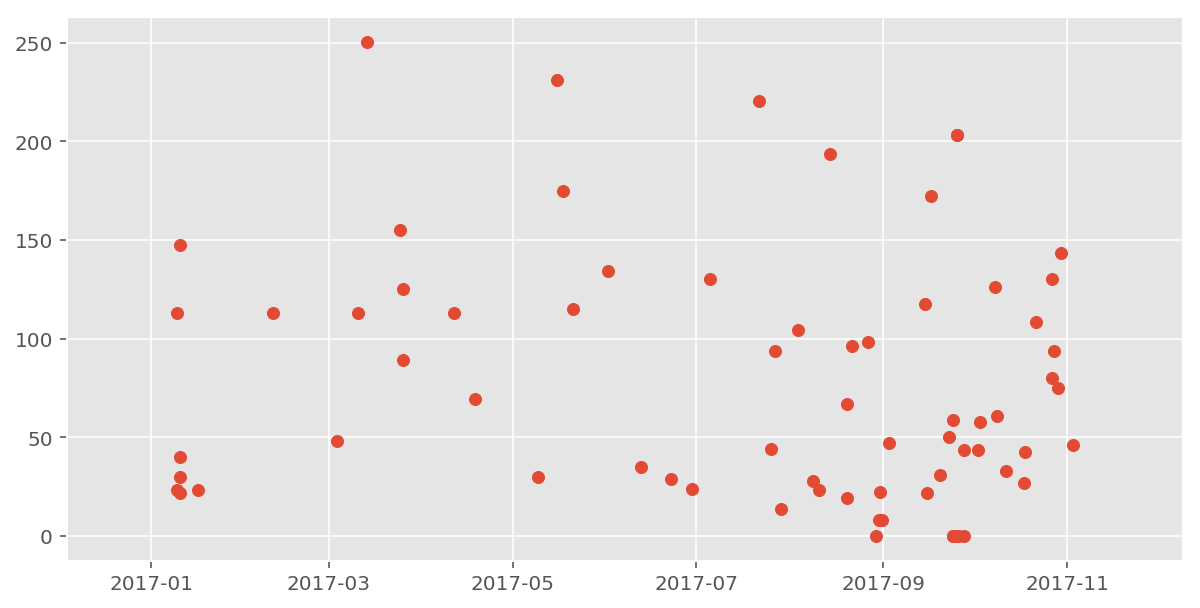

In [22]:
tr = trans_sorted.loc[np.random.choice(trans_sorted.index)].reset_index()

plt.figure(figsize=(10,5))
plt.scatter(tr['purchase_date'].values, tr.purchase_amount)

In [23]:
%%time

def duplicated_amounts(df, new_set=False):
    
    trans_sorted = (df[['card_id', 'purchase_date', 'purchase_amount']]
                    .sort_values(by=['card_id', 'purchase_date'])
                    .set_index('card_id')
                   )
    
    trans_sorted = trans_sorted[trans_sorted['purchase_amount'] != 0]
        
    duplicated_amounts = {}
    for card in tqdm_notebook(trans_sorted.index.unique()):
        try:
            tr = trans_sorted.loc[card].reset_index()
            duplicated_amount_rate = tr['purchase_amount'].duplicated().sum() / len(tr['purchase_amount'])
            avg_amount_per_day = (tr.groupby(['card_id', pd.Grouper(key='purchase_date', freq='D')])['purchase_amount']
                                  .mean()
                                  .reset_index()
                                  .set_index('purchase_date')
                                  .asfreq('1D')['purchase_amount']
                                  .fillna(0)
                                  .mean()
                                 )
            duplicated_amounts[card] = [duplicated_amount_rate, avg_amount_per_day]
        except:
            duplicated_amounts[card] = [0, 0]
            continue
            
    # save to df
    duplicated_amounts_df = pd.DataFrame().from_dict(
        duplicated_amounts, 
        orient='index', 
        columns=['duplicated_amount_rate', 'avg_amount_per_day']
    )

    duplicated_amounts_df = (duplicated_amounts_df
                    .reset_index(drop=False)
                    .rename(columns={'index': 'card_id'})
                   )
    
    if new_set:
        duplicated_amounts_df.columns = 'new_' + duplicated_amounts_df.columns
        duplicated_amounts_df = duplicated_amounts_df.rename(columns={'new_card_id': 'card_id'})
    else:
        duplicated_amounts_df.columns = 'old_' + duplicated_amounts_df.columns
        duplicated_amounts_df = duplicated_amounts_df.rename(columns={'old_card_id': 'card_id'})
    
    return duplicated_amounts_df

old_duplicated_amounts_df = duplicated_amounts(old_trans)
new_duplicated_amounts_df = duplicated_amounts(new_trans, new_set=True)

# save to csv
old_duplicated_amounts_df.to_csv('saved_features_24-02/old_duplicated_amounts_df.csv')
new_duplicated_amounts_df.to_csv('saved_features_24-02/new_duplicated_amounts_df.csv')


CPU times: user 53min 3s, sys: 3min 39s, total: 56min 43s
Wall time: 54min 27s


In [24]:
old_duplicated_amounts_df.head()

,card_id,old_duplicated_amount_rate,old_avg_amount_per_day
0,C_ID_00007093c1,0.342105,25.312197
1,C_ID_0001238066,0.133333,46.098254
2,C_ID_0001506ef0,0.112903,20.723840
3,C_ID_0001793786,0.052910,105.730191
4,C_ID_000183fdda,0.167883,62.700468


# 7. User profile -> PCA decompostion

In [6]:
# %%time

# def load_transactions(path_to_file):
    
#     df = pd.read_csv(path_to_file)
    
#     df['purchase_date'] = pd.to_datetime(df['purchase_date'])
#     df['purchase_amount'] = df['purchase_amount'].transform(lambda x: 1 / (1 + np.exp(-x)))
#     df['authorized_flag'] = df['authorized_flag'].map({'Y': 1, 'N': 0})

#     return df

# old_trans = load_transactions('../../all/historical_transactions.csv')
# new_trans = load_transactions('../../all/new_merchant_transactions.csv')

# # and replace
# old_trans.loc[old_trans['authorized_flag'] == 0, 'purchase_amount'] = 0

CPU times: user 4min 15s, sys: 1min 7s, total: 5min 23s
Wall time: 5min 38s


### `mercant_category_id`

In [25]:
old_profile_cnt = old_trans[['card_id', 'merchant_category_id']]
new_profile_cnt = new_trans[['card_id', 'merchant_category_id']]

In [26]:
%%time
old_pivot_profile_cnt = pd.pivot_table(old_profile_cnt, index='card_id', columns='merchant_category_id', aggfunc=len, fill_value=0)
new_pivot_profile_cnt = pd.pivot_table(new_profile_cnt, index='card_id', columns='merchant_category_id', aggfunc=len, fill_value=0)

CPU times: user 1min 12s, sys: 5.52 s, total: 1min 18s
Wall time: 1min 18s


In [27]:
from sklearn.decomposition import PCA

def PCA_decomposition(pivot, size, feature_name):
    
    pca = PCA(n_components=size)
    
    X = pivot.values
    pca.fit(X)
    X = pca.transform(X)
    print(pca.explained_variance_ratio_)  

    pca_df = pd.DataFrame({'card_id': pivot.index})

    for i in range(size):
        pca_comp = feature_name + str(i+1)
        pca_df[pca_comp] = X[:, i]
        
    return pca_df

old_merch_pca_df = PCA_decomposition(pivot=old_pivot_profile_cnt, size=12, feature_name='old_pca_merch_cnt_')
new_merch_pca_df = PCA_decomposition(pivot=new_pivot_profile_cnt, size=15, feature_name='new_pca_merch_cnt_')

[0.40595647 0.14527074 0.09413472 0.04954774 0.03704767 0.03663834
 0.02893731 0.02834247 0.02712439 0.01912871 0.01293145 0.01097573]
[0.27487421 0.11521593 0.07477918 0.05964435 0.04470277 0.0245326
 0.02234172 0.01996616 0.0153003  0.01373557 0.012818   0.01202744
 0.01162211 0.01108253 0.01084075]


In [29]:
merch_pca_df = old_merch_pca_df.merge(new_merch_pca_df, on='card_id', how='left')
merch_pca_df.to_csv('saved_features_24-02/merch_pca_df.csv')

### `purchase_amount` by week

In [32]:
%%time
old_trans_sorted = (old_trans[['card_id', 'purchase_date', 'purchase_amount']]
                .sort_values(by=['card_id', 'purchase_date'])
                .groupby(['card_id', pd.Grouper(key='purchase_date', freq='W-MON')])['purchase_amount']
                .sum()
                .reset_index()
                )

old_pivot_profile_purch = pd.pivot_table(old_trans_sorted, index='card_id', columns='purchase_date', values='purchase_amount', fill_value=0)

CPU times: user 1min 36s, sys: 10.6 s, total: 1min 47s
Wall time: 1min 47s


In [40]:
from sklearn.decomposition import PCA

def PCA_decomposition(pivot, size, feature_name):
    
    pca = PCA(n_components=size)
    
    X = pivot.values
    pca.fit(X)
    X = pca.transform(X)
    print(pca.explained_variance_ratio_)  

    pca_df = pd.DataFrame({'card_id': pivot.index})

    for i in range(size):
        pca_comp = feature_name + str(i+1)
        pca_df[pca_comp] = X[:, i]
        
    return pca_df

old_purch_pca_df = PCA_decomposition(pivot=old_pivot_profile_purch, size=10, feature_name='pca_purch_cnt_')

old_purch_pca_df.to_csv('saved_features_24-02/old_purch_pca_df.csv')

[0.22240919 0.07416496 0.04734598 0.03963076 0.02630633 0.02384644
 0.02187936 0.02065191 0.01944559 0.01896929]


In [41]:
%%time
new_trans_sorted = (new_trans[['card_id', 'purchase_date', 'purchase_amount']]
                .sort_values(by=['card_id', 'purchase_date'])
                .groupby(['card_id', pd.Grouper(key='purchase_date', freq='W-MON')])['purchase_amount']
                .sum()
                .reset_index()
                )

new_pivot_profile_purch = pd.pivot_table(new_trans_sorted, index='card_id', columns='purchase_date', values='purchase_amount', fill_value=0)

new_purch_pca_df = PCA_decomposition(pivot=new_pivot_profile_purch, size=10, feature_name='pca_purch_cnt_')

new_purch_pca_df.to_csv('saved_features_24-02/new_purch_pca_df.csv')

[0.16005049 0.11115041 0.0952448  0.08788487 0.08244513 0.07685075
 0.07479101 0.06122007 0.05327944 0.02403504]
CPU times: user 17.5 s, sys: 7.29 s, total: 24.8 s
Wall time: 17.4 s


### ~~ `subsector_id` ~~

In [42]:
old_profile_cnt = old_trans[['card_id', 'subsector_id', 'purchase_amount']]
new_profile_cnt = new_trans[['card_id', 'subsector_id', 'purchase_amount']]

In [43]:
%%time
old_pivot_profile_cnt = pd.pivot_table(old_profile_cnt, index='card_id', columns='subsector_id', aggfunc=len, fill_value=0)
new_pivot_profile_cnt = pd.pivot_table(new_profile_cnt, index='card_id', columns='subsector_id', aggfunc=len, fill_value=0)

CPU times: user 40.7 s, sys: 3 s, total: 43.7 s
Wall time: 43.7 s


In [44]:
from sklearn.decomposition import PCA

def PCA_decomposition(pivot, size, feature_name):
    
    pca = PCA(n_components=size)
    
    X = pivot.values
    pca.fit(X)
    X = pca.transform(X)
    print(pca.explained_variance_ratio_)  

    pca_df = pd.DataFrame({'card_id': pivot.index})

    for i in range(size):
        pca_comp = feature_name + str(i+1)
        pca_df[pca_comp] = X[:, i]
        
    return pca_df

old_sector_pca_df = PCA_decomposition(pivot=old_pivot_profile_cnt, size=5, feature_name='subsector_id')

old_sector_pca_df.to_csv('saved_features_24-02/old_sector_pca_df.csv')

[0.45168226 0.1694129  0.08890155 0.07411336 0.05093714]


For each category we can calculate typical number that shows how possible purchase will occure (using old_trans).

In [46]:
matrix = old_pivot_profile_cnt.values
prob_sector = matrix.sum(axis=0) / matrix.sum()
matrix_prob = matrix * prob_sector

print(matrix_prob)

[[0.         0.09552822 0.         ... 0.         0.         0.        ]
 [0.         0.09552822 0.         ... 0.01780728 0.         0.        ]
 [0.         0.02388205 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.04776411 0.         ... 0.         0.         0.00673659]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [47]:
from sklearn.decomposition import PCA

def PCA_decomposition(pivot, size, feature_name):
    
    pca = PCA(n_components=size)
    
#     X = pivot.values
    X = matrix_prob
    pca.fit(X)
    X = pca.transform(X)
    print(pca.explained_variance_ratio_)  

    pca_df = pd.DataFrame({'card_id': pivot.index})

    for i in range(size):
        pca_comp = feature_name + str(i+1)
        pca_df[pca_comp] = X[:, i]
        
    return pca_df

old_sector_pca_df = PCA_decomposition(pivot=old_pivot_profile_cnt, size=5, feature_name='subsector_id')

# old_sector_pca_df.to_csv('saved_features_24-02/old_sector_pca_df.csv')

[0.61665681 0.25500948 0.05687386 0.03794417 0.02579991]


In [48]:
old_sector_pca_df.head()

,card_id,subsector_id1,subsector_id2,subsector_id3,subsector_id4,subsector_id5
0,C_ID_00007093c1,1.706716,2.939105,4.130872,-0.887366,-0.305834
1,C_ID_0001238066,2.395234,-0.308854,2.137899,-0.996834,-0.498066
2,C_ID_0001506ef0,-0.015292,2.628992,-0.744942,0.044284,-0.316947
3,C_ID_0001793786,4.674191,-3.063607,-1.296047,-0.777972,-1.050947
4,C_ID_000183fdda,-1.596206,-2.509405,0.364736,-0.146221,-0.403808


#### How possible to move from one category (odl_trans) to another (new_trans)
    
    to do

### modified sector_id

In [49]:
old_profile_cnt = old_trans[['card_id', 'subsector_id', 'purchase_amount']]
new_profile_cnt = new_trans[['card_id', 'subsector_id', 'purchase_amount']]

In [50]:
%%time
old_pivot_profile_cnt = pd.pivot_table(old_profile_cnt, index='card_id', columns='subsector_id', values='purchase_amount',
                                       aggfunc='mean', fill_value=0)
new_pivot_profile_cnt = pd.pivot_table(new_profile_cnt, index='card_id', columns='subsector_id', values='purchase_amount',
                                       aggfunc='mean', fill_value=0)

CPU times: user 7.87 s, sys: 1.47 s, total: 9.34 s
Wall time: 9.36 s


In [51]:
old_ex = old_pivot_profile_cnt.reset_index()
new_ex = new_pivot_profile_cnt.reset_index()

old_new = old_ex.merge(new_ex, on='card_id', how='left')
old_new.fillna(0, inplace=True)

In [52]:
old_new.head()

subsector_id,card_id,-1_x,1_x,2_x,3_x,4_x,5_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,20_x,21_x,22_x,23_x,24_x,25_x,26_x,27_x,28_x,29_x,30_x,31_x,32_x,33_x,34_x,35_x,36_x,37_x,38_x,39_x,40_x,41_x,-1_y,1_y,2_y,3_y,4_y,5_y,7_y,8_y,9_y,10_y,11_y,12_y,13_y,14_y,15_y,16_y,17_y,18_y,19_y,20_y,21_y,22_y,23_y,24_y,25_y,26_y,27_y,28_y,29_y,30_y,31_y,32_y,33_y,34_y,35_y,36_y,37_y,38_y,39_y,40_y,41_y
0,C_ID_00007093c1,0.0,197.097500,0.000000,0.0,0.0,0.0,0.000000,17.10,0.00,123.965,0.0,82.140000,0.000,0.0,207.810000,72.630000,0.0,253.215385,77.125000,0.000,140.532857,0.0,0.0,0.0,0.000000,0.0,126.697500,0.0,110.190000,0.00,0.0,0.00,124.227742,105.757143,0.00,0.000000,0.000000,0.00,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0000,0.00,0.00,0.000000,0.0,50.09,0.0,0.0,0.00,0.00,0.0,0.00,0.0,60.110000,0.00,0.00,0.0,0.000,0.00,0.0,0.00,0.00000,0.0,0.0,0.0,0.00
1,C_ID_0001238066,0.0,165.065000,0.000000,1010.0,0.0,0.0,161.486667,0.00,0.00,661.170,0.0,211.475000,0.000,0.0,30.200000,58.514000,0.0,0.000000,81.850294,0.000,0.000000,0.0,0.0,0.0,0.000000,0.0,106.450000,0.0,127.416667,452.80,0.0,0.00,120.329231,43.322500,0.00,12.420000,43.815000,220.39,10.515,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,44.08,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,41.7300,38.82,0.00,93.654000,0.0,0.00,0.0,0.0,0.00,0.00,0.0,215.83,0.0,158.236000,0.00,124.76,0.0,120.090,0.00,0.0,0.00,118.00625,0.0,0.0,0.0,0.00
2,C_ID_0001506ef0,0.0,12.020000,0.000000,0.0,0.0,0.0,0.000000,3.14,0.00,0.000,0.0,0.000000,0.000,0.0,55.268571,31.397500,0.0,0.000000,68.120000,0.000,46.113333,0.0,0.0,0.0,39.070000,0.0,58.790000,0.0,19.852857,0.00,0.0,0.00,325.239600,2.140000,0.00,0.000000,79.140000,0.00,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0000,0.00,0.00,0.000000,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.000000,0.00,0.00,0.0,9.940,21.04,0.0,0.00,0.00000,0.0,0.0,0.0,0.00
3,C_ID_0001793786,0.0,661.195556,285.836667,0.0,0.0,0.0,106.246667,0.00,1478.19,0.000,0.0,260.352857,103.935,0.0,123.240000,150.597000,0.0,696.230000,194.903333,194.795,1092.123333,0.0,0.0,0.0,250.040000,0.0,825.331379,0.0,218.715556,591.22,0.0,0.00,634.651000,133.275714,0.00,220.061667,112.589583,567.00,0.000,0.0,38.367,0.0,0.0,0.0,0.0,0.0,0.0,130.23,0.0,0.0,0.0,0.0,899.73,0.0,0.0,0.0,82.5800,0.00,0.00,192.673333,0.0,2584.56,0.0,0.0,6.01,170.30,0.0,674.59,0.0,577.186667,256.85,0.00,0.0,1282.265,0.00,0.0,50.09,328.07700,0.0,0.0,0.0,249.44
4,C_ID_000183fdda,0.0,491.307500,1192.100000,0.0,0.0,0.0,69.956667,0.00,0.00,0.000,0.0,64.730000,0.000,0.0,47.700000,81.380357,0.0,0.000000,81.222308,100.170,2341.130000,0.0,0.0,0.0,46.773077,0.0,155.375238,0.0,72.640000,260.49,0.0,305.14,63.056667,20.980000,981.73,385.906667,54.899545,85.13,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,202.6025,0.00,21.04,0.000000,0.0,0.00,0.0,0.0,0.00,14.02,0.0,57.55,0.0,36.040000,0.00,0.00,0.0,0.000,0.00,0.0,0.00,43.43000,0.0,0.0,0.0,0.00


In [53]:
diff_cash_sector = pd.DataFrame({'card_id': old_new['card_id']})

for col in ['-1', '1', '2', '3', '4', '5', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', 
            '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', 
            '32', '33', '34', '35', '36', '37', '38', '39', '40', '41']:
    
    col_name = 'sec_' + col + '_diff'
    col_old = col + '_x'
    col_new = col + '_y'
    diff_cash_sector[col_name] = old_new[col_new] - old_new[col_old]   
    

In [54]:
diff_cash_sector.head()

,card_id,sec_-1_diff,sec_1_diff,sec_2_diff,sec_3_diff,sec_4_diff,sec_5_diff,sec_7_diff,sec_8_diff,sec_9_diff,sec_10_diff,sec_11_diff,sec_12_diff,sec_13_diff,sec_14_diff,sec_15_diff,sec_16_diff,sec_17_diff,sec_18_diff,sec_19_diff,sec_20_diff,sec_21_diff,sec_22_diff,sec_23_diff,sec_24_diff,sec_25_diff,sec_26_diff,sec_27_diff,sec_28_diff,sec_29_diff,sec_30_diff,sec_31_diff,sec_32_diff,sec_33_diff,sec_34_diff,sec_35_diff,sec_36_diff,sec_37_diff,sec_38_diff,sec_39_diff,sec_40_diff,sec_41_diff
0,C_ID_00007093c1,0.0,-197.097500,0.000000,0.0,0.0,0.0,0.000000,-17.10,0.00,-123.965,0.0,-82.140000,0.000,0.0,-207.810000,-72.630000,0.00,-253.215385,-77.125000,0.000,-90.442857,0.0,0.0,0.00,0.000000,0.0,-126.697500,0.0,-50.080000,0.00,0.00,0.00,-124.227742,-105.757143,0.00,0.000000,0.000000,0.00,0.000,0.0,0.000
1,C_ID_0001238066,0.0,-165.065000,0.000000,-1010.0,0.0,0.0,-117.406667,0.00,0.00,-661.170,0.0,-211.475000,0.000,0.0,-30.200000,-16.784000,38.82,0.000000,11.803706,0.000,0.000000,0.0,0.0,0.00,0.000000,0.0,109.380000,0.0,30.819333,-452.80,124.76,0.00,-0.239231,-43.322500,0.00,-12.420000,74.191250,-220.39,-10.515,0.0,0.000
2,C_ID_0001506ef0,0.0,-12.020000,0.000000,0.0,0.0,0.0,0.000000,-3.14,0.00,0.000,0.0,0.000000,0.000,0.0,-55.268571,-31.397500,0.00,0.000000,-68.120000,0.000,-46.113333,0.0,0.0,0.00,-39.070000,0.0,-58.790000,0.0,-19.852857,0.00,0.00,0.00,-315.299600,18.900000,0.00,0.000000,-79.140000,0.00,0.000,0.0,0.000
3,C_ID_0001793786,0.0,-661.195556,-285.836667,0.0,0.0,0.0,23.983333,0.00,-1478.19,0.000,0.0,639.377143,-103.935,0.0,-123.240000,-68.017000,0.00,-696.230000,-2.230000,-194.795,1492.436667,0.0,0.0,6.01,-79.740000,0.0,-150.741379,0.0,358.471111,-334.37,0.00,0.00,647.614000,-133.275714,0.00,-169.971667,215.487417,-567.00,0.000,0.0,211.073
4,C_ID_000183fdda,0.0,-491.307500,-1192.100000,0.0,0.0,0.0,-69.956667,0.00,0.00,0.000,0.0,-64.730000,0.000,0.0,-47.700000,121.222143,0.00,21.040000,-81.222308,-100.170,-2341.130000,0.0,0.0,0.00,-32.753077,0.0,-97.825238,0.0,-36.600000,-260.49,0.00,-305.14,-63.056667,-20.980000,-981.73,-385.906667,-11.469545,-85.13,0.000,0.0,0.000


In [58]:
from sklearn.decomposition import PCA

def PCA_decomposition(size, feature_name):
    
    pca = PCA(n_components=size)
    
    X = diff_cash_sector.iloc[:, 1:].values
    pca.fit(X)
    X = pca.transform(X)
    print(pca.explained_variance_ratio_)  

    pca_df = pd.DataFrame({'card_id': diff_cash_sector.card_id})

    for i in range(size):
        pca_comp = feature_name + str(i+1)
        pca_df[pca_comp] = X[:, i]
        
    return pca_df

diff_sector_pca_df = PCA_decomposition(size=20, feature_name='sector_diff')

diff_sector_pca_df.to_csv('saved_features_24-02/diff_sector_pca_df.csv')

[0.15104952 0.10289478 0.08853324 0.07037142 0.06891441 0.05091563
 0.04827187 0.04236492 0.03987429 0.03551413 0.03300572 0.03243578
 0.03218365 0.02773134 0.02330417 0.02098656 0.02001876 0.01349332
 0.01203715 0.01118644]


#  ---

#   ~~ that's it ~~

#  ---

# Survival analysis

We are guessing that users with -33 loyalty score have been churned. Using `outliers` we can build KaplanMeierFitter model and encode some categorial features. Also we can perform Cox Regression!

In [10]:
!pip install tqdm lifelines

from lifelines import CoxPHFitter, KaplanMeierFitter

  Using cached https://files.pythonhosted.org/packages/e6/f4/408183aee57b9625805b02441e761fedf32c29559e4be15823afee375de5/lifelines-0.19.5-py2.py3-none-any.whl
You are using pip version 18.0, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [11]:
%%time
trans = pd.concat([old_trans, new_trans])

CPU times: user 28 s, sys: 2.8 s, total: 30.8 s
Wall time: 30.6 s


In [ ]:
%%time

aggs = {'purchase_date': ['min', 'max']} 
trans_minmax = trans[['card_id', 'purchase_date']].groupby('card_id').agg(['min', 'max'])

trans_minmax.columns = ['agg_' + k + '_' + str(agg) for k in aggs.keys() for agg in aggs[k]]
trans_minmax.reset_index(drop=False, inplace=True)

trans_minmax['T'] = (trans_minmax['agg_purchase_date_max'] - trans_minmax['agg_purchase_date_min']).dt.days
trans_minmax.drop(['agg_purchase_date_min', 'agg_purchase_date_max'], axis=1, inplace=True)

In [ ]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1

survival_df = trans_minmax.merge(df_train[['card_id', 'outliers', 'feature_1', 'feature_2', 'feature_3', 'only_old_base']], 
                                 on='card_id', how='inner')

In [ ]:
ax = plt.subplot(111)

kmf = KaplanMeierFitter()

for name, grouped_df in survival_df.groupby('feature_2'):
    kmf.fit(grouped_df["T"], grouped_df["outliers"], label=name)
    kmf.plot(ax=ax, figsize=(10,5))
    print(kmf.survival_function_.cumsum().reset_index()[name].iloc[-1])

In [ ]:
kmf = KaplanMeierFitter()

survival_analyse = {}
for feature in ['feature_1', 'feature_2', 'feature_3', 'only_old_base']:
    for name, grouped_df in survival_df.groupby(feature):
        kmf.fit(grouped_df["T"], grouped_df["outliers"], label=name)
        survival_analyse[feature, name] = kmf.survival_function_.cumsum().reset_index()[name].iloc[-1]
        
survival_analyse

In [ ]:
# for df in [df_train, df_test]:
    
#     df['feature_1_sa'] = df['feature_1'].map(
#         {1: survival_analyse[('feature_1', 1)], 
#          2: survival_analyse[('feature_1', 2)],
#          3: survival_analyse[('feature_1', 3)],
#          4: survival_analyse[('feature_1', 4)], 
#          5: survival_analyse[('feature_1', 5)]}
#     )

#     df['feature_2_sa'] = df['feature_2'].map(
#         {1: survival_analyse[('feature_2', 1)], 
#          2: survival_analyse[('feature_2', 2)],
#          3: survival_analyse[('feature_2', 3)]}
#     )

#     df['feature_3_sa'] = df['feature_3'].map(
#         {0: survival_analyse[('feature_3', 0)], 
#          1: survival_analyse[('feature_3', 1)]}
#     )

#     df['only_old_base_sa'] = df['only_old_base'].map(
#         {0: survival_analyse[('only_old_base', 0)], 
#          1: survival_analyse[('only_old_base', 1)]}
#     )

# Holidays

In [37]:
%%time

def load_holidays(path_to_file):

    df = pd.read_csv(path_to_file, usecols=['card_id', 'purchase_date', 'purchase_amount', 'authorized_flag'])
    df['purchase_amount'] = df['purchase_amount'].apply(lambda x: 1 / (1 + np.exp(-x)))
    df = df[(df['purchase_amount'] >= 0.4) & (df['authorized_flag'] == 'Y')]
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    
    # holidays effect
    df['Christmas_Day_2017'] = (pd.to_datetime('2017-12-25') - df['purchase_date']).dt.days.apply(lambda x: 1 if x > 0 and x < 30 else 0)
    df['Mothers_Day_2017'] = (pd.to_datetime('2017-06-04') - df['purchase_date']).dt.days.apply(lambda x: 1 if x > 0 and x < 30 else 0)
    df['Fathers_day_2017'] = (pd.to_datetime('2017-08-13') - df['purchase_date']).dt.days.apply(lambda x: 1 if x > 0 and x < 30 else 0)
    df['Children_day_2017'] = (pd.to_datetime('2017-10-12') - df['purchase_date']).dt.days.apply(lambda x: 1 if x > 0 and x < 30 else 0)
    df['Valentine_Day_2017'] = (pd.to_datetime('2017-06-12') - df['purchase_date']).dt.days.apply(lambda x: 1 if x > 0 and x < 30 else 0)
    df['Black_Friday_2017'] = (pd.to_datetime('2017-11-24') - df['purchase_date']).dt.days.apply(lambda x: 1 if x > 0 and x < 30 else 0)
    df['Mothers_Day_2018'] = (pd.to_datetime('2018-05-13') - df['purchase_date']).dt.days.apply(lambda x: 1 if x > 0 and x < 30 else 0)
    
    return df

old_holidays = load_holidays('../../all/historical_transactions.csv')
new_holidays = load_holidays('../../all/new_merchant_transactions.csv')

CPU times: user 2min 27s, sys: 4.66 s, total: 2min 31s
Wall time: 2min 43s


In [64]:
old_holidays_limited = old_holidays[['card_id', 'purchase_amount', 'Christmas_Day_2017', 'Mothers_Day_2017', 'Fathers_day_2017',
       'Children_day_2017', 'Valentine_Day_2017', 'Black_Friday_2017',
       'Mothers_Day_2018']].sort_values(by='card_id')
old_holidays_limited.set_index('card_id', inplace=True)

In [75]:
holidays_effect = dict()
for card_id in tqdm_notebook(old_holidays['card_id'].unique()):
    
    example = old_holidays_limited.loc[card_id]
    
    # Christmas_Day_2017
    example_cristmas = (example['purchase_amount'] * example['Christmas_Day_2017']).sum()
    
    # Mothers_Day_2017
    example_mothers_day_17 = (example['purchase_amount'] * example['Mothers_Day_2017']).sum()

    # Black_Friday_2017
    example_BF_17 = (example['purchase_amount'] * example['Black_Friday_2017']).sum()
    
    # Mothers_Day_2018
    example_mothers_day_18 = (example['purchase_amount'] * example['Mothers_Day_2018']).sum()

    holidays_effect[card_id] = [example_cristmas, example_mothers_day_17, example_BF_17, example_mothers_day_18]

In [76]:
# save to df
holidays_df = pd.DataFrame().from_dict(
    holidays_effect, 
    orient='index', 
    columns=['example_cristmas', 'example_mothers_day_17', 'example_BF_17', 'example_mothers_day_18']
)

holidays_df = (holidays_df
                .reset_index(drop=False)
                .rename(columns={'index': 'card_id'})
               )

holidays_df.columns = 'old_' + holidays_df.columns
holidays_df = holidays_df.rename(columns={'old_card_id': 'card_id'})

In [78]:
holidays_df.head()

,card_id,old_example_cristmas,old_example_mothers_day_17,old_example_BF_17,old_example_mothers_day_18
0,C_ID_4e6213e9bc,0.000000,0.0,0.000000,0.0
1,C_ID_5037ff576e,0.560833,0.0,1.187311,0.0
2,C_ID_0e171c1b48,0.403891,0.0,0.000000,0.0
3,C_ID_48fb13e70f,0.000000,0.0,0.906255,0.0
4,C_ID_fc8e41b9cf,3.350327,0.0,2.615564,0.0
